# Cyclistic Case Study: Rolling Year Workflow (Dec 2024 – Nov 2025)

This notebook documents the process of downloading, cleaning, and analyzing Divvy bike-share data
for a rolling year timeframe.  
**Note:** The dataset covers Dec 2024 – Nov 2025, which is the most recent complete 12-month cycle available.
This preserves seasonality but is offset from the calendar year (Jan–Dec).


In [17]:
# Import libraries
import requests, zipfile, io, os
import pandas as pd

# Create folder for extracted data
os.makedirs("divvy_data", exist_ok=True)

# Define URLs for Dec 2024 – Nov 2025
urls = [
    "https://divvy-tripdata.s3.amazonaws.com/202412-divvy-tripdata.zip"
] + [
    f"https://divvy-tripdata.s3.amazonaws.com/2025{month:02d}-divvy-tripdata.zip"
    for month in range(1, 12)
]
urls


['https://divvy-tripdata.s3.amazonaws.com/202412-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202501-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202502-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202503-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202504-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202505-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202506-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202507-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202508-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202509-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202510-divvy-tripdata.zip',
 'https://divvy-tripdata.s3.amazonaws.com/202511-divvy-tripdata.zip']

In [19]:
for url in urls:
    print(f"Downloading {url}...")
    r = requests.get(url)
    if r.status_code == 200:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall("divvy_data")
    else:
        print(f"Failed to download {url}")


In [21]:
# Collect all CSV files
all_files = [os.path.join("divvy_data", f) for f in os.listdir("divvy_data") if f.endswith(".csv")]

# Concatenate into one DataFrame
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)

print("Shape:", df.shape)
df.head()


Shape: (5925907, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,578DDD7CE1771FFA,classic_bike,2024-11-07 19:21:58.206,2024-11-07 19:28:57.301,Walsh Park,18067,Leavitt St & North Ave,TA1308000005,41.914610,-87.667968,41.910533,-87.682308,member
1,78B141C50102ABA6,classic_bike,2024-11-22 14:49:00.431,2024-11-22 14:56:15.475,Walsh Park,18067,Leavitt St & Armitage Ave,TA1309000029,41.914610,-87.667968,41.917805,-87.682437,member
2,1E794CF36394E2D7,classic_bike,2024-11-08 09:24:00.238,2024-11-08 09:28:33.480,Walsh Park,18067,Damen Ave & Cortland St,13133,41.914610,-87.667968,41.915983,-87.677335,member
3,E5DD2CAB58D73F98,classic_bike,2024-11-24 17:51:14.144,2024-11-24 18:05:32.574,Clark St & Elm St,TA1307000039,Clark St & Drummond Pl,TA1307000142,41.902973,-87.631280,41.931248,-87.644336,member
4,57F9878BC8C765F1,classic_bike,2024-11-04 14:59:16.032,2024-11-04 15:41:02.456,Clark St & Wellington Ave,TA1307000136,Streeter Dr & Grand Ave,13022,41.936497,-87.647539,41.892278,-87.612043,casual


In [23]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Convert datetime columns
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Add year-month column for grouping
df['year_month'] = df['started_at'].dt.to_period('M')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5925907 entries, 0 to 5925906
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  year_month          period[M]     
dtypes: datetime64[ns](2), float64(4), object(7), period[M](1)
memory usage: 633.0+ MB


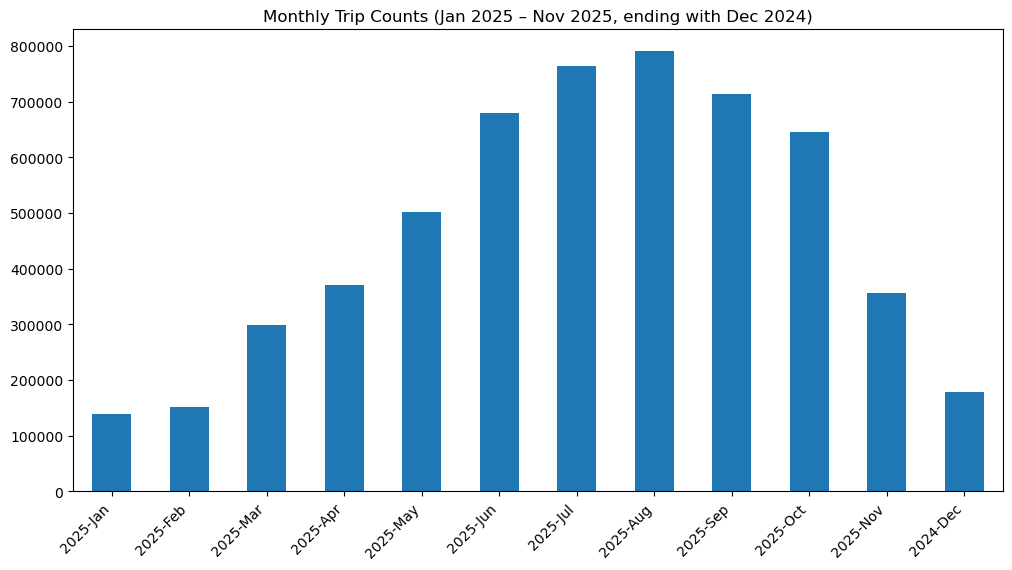

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot with rotation
ax = monthly_counts.plot(
    kind='bar',
    figsize=(12,6),
    title="Monthly Trip Counts (Jan 2025 – Nov 2025, ending with Dec 2024)"
)

# Rotate x-axis labels 45 degrees for readability
plt.xticks(rotation=45, ha='right')

plt.show()

# Ensure datetime conversion
df['started_at'] = pd.to_datetime(df['started_at'])

# Create year-month Period column
df['year_month'] = df['started_at'].dt.to_period('M')

# Filter to rolling year: Dec 2024 – Nov 2025
mask = (df['started_at'] >= "2024-12-01") & (df['started_at'] < "2025-12-01")
df_filtered = df.loc[mask].copy()

# Group by year-month and sort chronologically
monthly_counts = df_filtered.groupby('year_month').size().sort_index()

# Relabel index to YYYY-MMM for readability
monthly_counts.index = monthly_counts.index.strftime('%Y-%b')

# Reorder manually: Jan–Nov 2025 first, then Dec 2024 last
order = [f"2025-{month:02d}" for month in range(1, 12)] + ["2024-12"]
order = pd.PeriodIndex(order, freq="M")

# IMPORTANT: match PeriodIndex before relabeling
monthly_counts = df_filtered.groupby('year_month').size().reindex(order)

# Relabel again for plotting
monthly_counts.index = monthly_counts.index.strftime('%Y-%b')


## Timeframe Notes
- This dataset covers **Dec 2024 – Nov 2025**, a rolling year.
- Seasonality is preserved (all four seasons are included).
- Comparisons to external datasets (weather, tourism, city reports) may require alignment to Jan–Dec.
- Transparency: Document this choice in the case study report.
